# Analisi Filtro Vincite Consecutive
## Strategia per Catturare i Periodi Profittevoli

L'obiettivo è creare un filtro che:
1. **Identifichi sequenze di vincite consecutive** nella strategia
2. **Attivi la strategia** quando inizia una sequenza favorevole
3. **Disattivi la strategia** quando la sequenza si interrompe o raggiunge un certo numero di perdite
4. **Eviti completamente il lookahead bias** usando solo informazioni passate

### Metodologia
- Analisi delle performance storiche per identificare pattern
- Creazione di un sistema di soglie dinamiche
- Test di diverse configurazioni per ottimizzare i parametri
- Confronto con la strategia originale

📊 CARICAMENTO E ANALISI STRUTTURA DATI
📋 INFORMAZIONI DATASET:
   Colonne disponibili: ['DATE', 'BALANCE', 'EQUITY', 'DEPOSIT LOAD']
   Numero di righe: 6194
   Periodo: 2024-01-01 00:00:00 - 2025-07-02 23:59:00

🔍 ANALISI STRUTTURA TEMPORALE:
   Differenza temporale media: 0 days 02:07:39.218472468
   Differenza temporale mediana: 0 days 00:16:00
   Min differenza: 0 days 00:00:00
   Max differenza: 4 days 22:46:00

📋 PRIMI 10 RECORD:
                 DATE   BALANCE    EQUITY  DEPOSIT LOAD       time_diff
0 2024-01-01 00:00:00  10000.00  10000.00        0.0000             NaT
1 2024-01-02 09:09:00   9998.28   9995.61        0.0000 1 days 09:09:00
2 2024-01-02 12:01:00   9998.28   9998.28        0.0000 0 days 02:52:00
3 2024-01-02 12:13:00   9999.10   9998.21        0.0000 0 days 00:12:00
4 2024-01-02 12:18:00   9999.10   9999.10       33.3363 0 days 00:05:00
5 2024-01-02 12:18:00   9999.10   9999.10        0.0000 0 days 00:00:00
6 2024-01-02 12:27:00   9999.53   9998.59        0.0000 

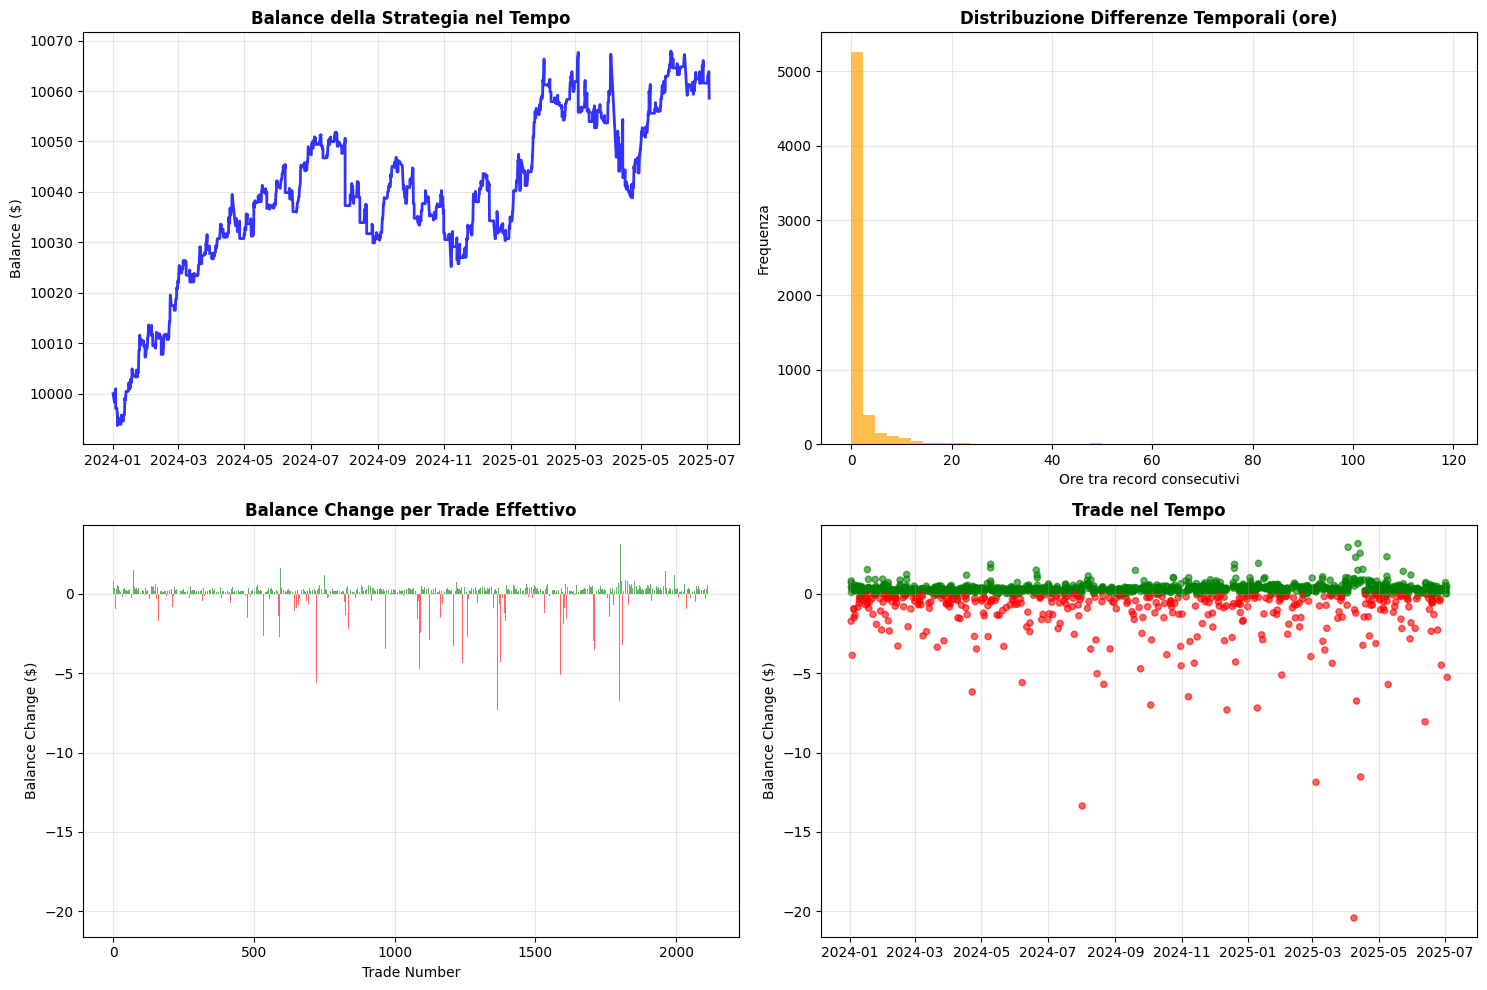


✅ DATASET PREPARATO PER ANALISI SEQUENZE:
   2118 trade effettivi identificati
   Periodo trade: 2024-01-02 09:09:00 - 2025-07-02 23:59:00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Carica i dati
print("📊 CARICAMENTO E ANALISI STRUTTURA DATI")
print("="*80)

# Leggi il file CSV con encoding corretto
df = pd.read_csv('/workspaces/bollingerBands/notebooks/DATA/eurgbp 1440_05.csv', 
                 sep='\t', encoding='utf-16')

# Pulisci i nomi delle colonne
df.columns = [col.strip('<>') for col in df.columns]

# Converti DATE in datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y.%m.%d %H:%M')

print(f"📋 INFORMAZIONI DATASET:")
print(f"   Colonne disponibili: {list(df.columns)}")
print(f"   Numero di righe: {len(df)}")
print(f"   Periodo: {df['DATE'].iloc[0]} - {df['DATE'].iloc[-1]}")

# Analizza la struttura temporale
print(f"\n🔍 ANALISI STRUTTURA TEMPORALE:")
df['time_diff'] = df['DATE'].diff()
print(f"   Differenza temporale media: {df['time_diff'].mean()}")
print(f"   Differenza temporale mediana: {df['time_diff'].median()}")
print(f"   Min differenza: {df['time_diff'].min()}")
print(f"   Max differenza: {df['time_diff'].max()}")

# Visualizza i primi dati per capire la struttura
print(f"\n📋 PRIMI 10 RECORD:")
print(df.head(10))

# Analizza come cambia il balance
df['balance_change'] = df['BALANCE'].diff()
df['balance_change_pct'] = df['BALANCE'].pct_change()

# Identifica i trade (quando il balance cambia)
df['is_trade'] = (df['balance_change'] != 0) & (df['balance_change'].notna())
actual_trades = df[df['is_trade']]

print(f"\n💼 ANALISI TRADE:")
print(f"   Righe totali nel dataset: {len(df)}")
print(f"   Righe dove il balance cambia (trade): {len(actual_trades)}")
print(f"   Righe dove il balance non cambia: {len(df) - len(actual_trades)}")

if len(actual_trades) > 0:
    print(f"   Balance change minimo: {actual_trades['balance_change'].min():.2f}")
    print(f"   Balance change massimo: {actual_trades['balance_change'].max():.2f}")
    print(f"   Balance change medio: {actual_trades['balance_change'].mean():.2f}")
    
    # Classifica trade come vincenti/perdenti
    actual_trades['is_win'] = actual_trades['balance_change'] > 0
    actual_trades['is_loss'] = actual_trades['balance_change'] < 0
    
    wins = actual_trades['is_win'].sum()
    losses = actual_trades['is_loss'].sum()
    total_trades = len(actual_trades)
    
    print(f"\n📊 STATISTICHE TRADE EFFETTIVI:")
    print(f"   Totale trade: {total_trades}")
    print(f"   Trade vincenti: {wins} ({wins/total_trades*100:.1f}%)")
    print(f"   Trade perdenti: {losses} ({losses/total_trades*100:.1f}%)")
    print(f"   Trade in pareggio: {total_trades - wins - losses}")

# Plot della struttura dei dati
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Balance nel tempo
ax1.plot(df['DATE'], df['BALANCE'], linewidth=2, color='blue', alpha=0.8)
ax1.set_title('Balance della Strategia nel Tempo', fontsize=12, fontweight='bold')
ax1.set_ylabel('Balance ($)')
ax1.grid(True, alpha=0.3)

# Plot 2: Differenze temporali
if len(df['time_diff'].dropna()) > 0:
    ax2.hist(df['time_diff'].dropna().dt.total_seconds() / 3600, bins=50, alpha=0.7, color='orange')
    ax2.set_title('Distribuzione Differenze Temporali (ore)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Ore tra record consecutivi')
    ax2.set_ylabel('Frequenza')
    ax2.grid(True, alpha=0.3)

# Plot 3: Balance changes (solo trade effettivi)
if len(actual_trades) > 0:
    colors = ['red' if x < 0 else 'green' for x in actual_trades['balance_change']]
    ax3.bar(range(len(actual_trades)), actual_trades['balance_change'], color=colors, alpha=0.6)
    ax3.set_title('Balance Change per Trade Effettivo', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Balance Change ($)')
    ax3.set_xlabel('Trade Number')
    ax3.grid(True, alpha=0.3)

# Plot 4: Trade nel tempo
if len(actual_trades) > 0:
    ax4.scatter(actual_trades['DATE'], actual_trades['balance_change'], 
               c=['red' if x < 0 else 'green' for x in actual_trades['balance_change']], 
               alpha=0.6, s=20)
    ax4.set_title('Trade nel Tempo', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Balance Change ($)')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prepara i dati per l'analisi delle sequenze consecutive
if len(actual_trades) > 0:
    # Ora lavoriamo solo sui trade effettivi
    trade_df = actual_trades.copy().reset_index(drop=True)
    print(f"\n✅ DATASET PREPARATO PER ANALISI SEQUENZE:")
    print(f"   {len(trade_df)} trade effettivi identificati")
    print(f"   Periodo trade: {trade_df['DATE'].iloc[0]} - {trade_df['DATE'].iloc[-1]}")
else:
    print("\n❌ ERRORE: Non sono stati identificati trade effettivi nel dataset")
    trade_df = None

print("="*80)

🔍 ANALISI SEQUENZE CONSECUTIVE SUI TRADE EFFETTIVI
📈 SEQUENZE DI VINCITE CONSECUTIVE:
   Numero di sequenze: 286
   Lunghezza media: 6.02
   Lunghezza mediana: 4.0
   Lunghezza massima: 30
   Lunghezza minima: 1
   Deviazione standard: 5.40

📉 SEQUENZE DI PERDITE CONSECUTIVE:
   Numero di sequenze: 287
   Lunghezza media: 1.38
   Lunghezza mediana: 1.0
   Lunghezza massima: 6
   Lunghezza minima: 1
   Deviazione standard: 0.77


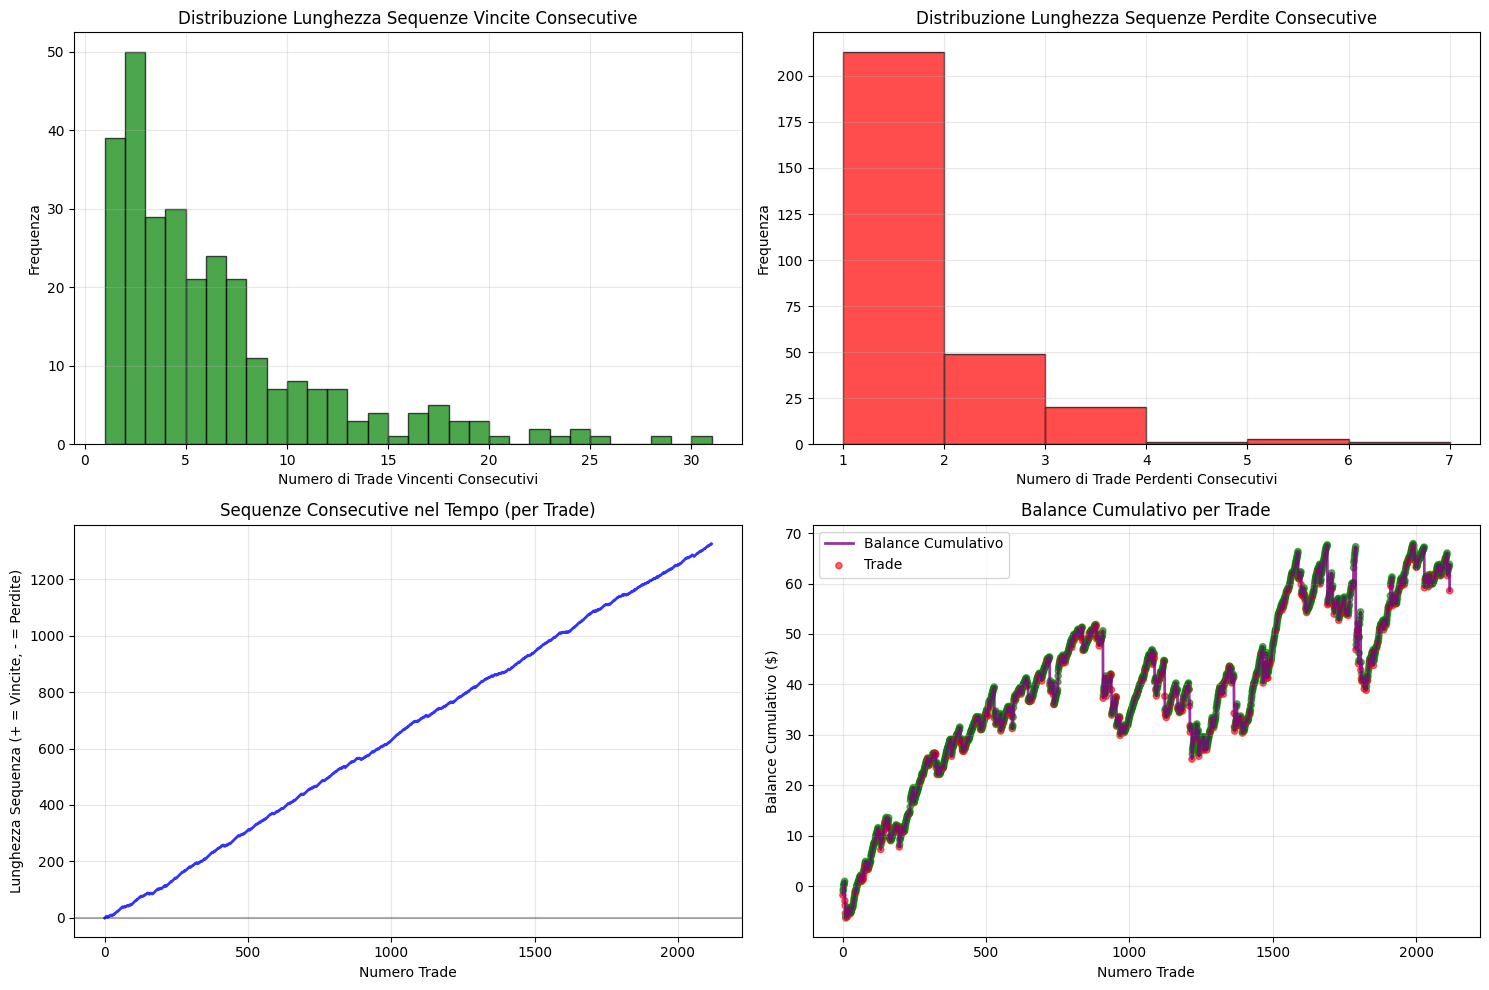


💡 OSSERVAZIONI CHIAVE:
✅ La strategia tende a fare 6.0 trade vincenti consecutivi in media
✅ La sequenza più lunga è stata di 30 trade vincenti consecutivi
❌ Le perdite consecutive durano 1.4 trade in media
❌ La sequenza perdente più lunga è stata di 6 trade consecutivi

🎯 POTENZIALE STRATEGIA:
   - Attivare la strategia dopo N trade vincenti consecutivi
   - Disattivare dopo M trade perdenti consecutivi
   - Monitorare il numero di trade invece che il tempo


In [17]:
def analyze_consecutive_patterns(trade_df):
    """
    Analizza le sequenze di vincite e perdite consecutive sui TRADE EFFETTIVI
    """
    if trade_df is None or len(trade_df) == 0:
        print("❌ ERRORE: Nessun trade effettivo da analizzare")
        return [], [], []
    
    print("🔍 ANALISI SEQUENZE CONSECUTIVE SUI TRADE EFFETTIVI")
    print("="*80)
    
    # Lavora sui trade effettivi
    wins = trade_df['is_win'].values
    losses = trade_df['is_loss'].values
    
    # Calcola sequenze di vincite e perdite consecutive
    consecutive_wins = []
    consecutive_losses = []
    
    current_win_streak = 0
    current_loss_streak = 0
    
    for i, (win, loss) in enumerate(zip(wins, losses)):
        if win:
            current_win_streak += 1
            if current_loss_streak > 0:
                consecutive_losses.append(current_loss_streak)
                current_loss_streak = 0
        elif loss:
            current_loss_streak += 1
            if current_win_streak > 0:
                consecutive_wins.append(current_win_streak)
                current_win_streak = 0
        # Se né win né loss (pareggio), interrompi entrambe le sequenze
        else:
            if current_win_streak > 0:
                consecutive_wins.append(current_win_streak)
                current_win_streak = 0
            if current_loss_streak > 0:
                consecutive_losses.append(current_loss_streak)
                current_loss_streak = 0
    
    # Aggiungi l'ultima sequenza se non terminata
    if current_win_streak > 0:
        consecutive_wins.append(current_win_streak)
    if current_loss_streak > 0:
        consecutive_losses.append(current_loss_streak)
    
    # Statistiche sequenze
    if consecutive_wins:
        print(f"📈 SEQUENZE DI VINCITE CONSECUTIVE:")
        print(f"   Numero di sequenze: {len(consecutive_wins)}")
        print(f"   Lunghezza media: {np.mean(consecutive_wins):.2f}")
        print(f"   Lunghezza mediana: {np.median(consecutive_wins):.1f}")
        print(f"   Lunghezza massima: {max(consecutive_wins)}")
        print(f"   Lunghezza minima: {min(consecutive_wins)}")
        print(f"   Deviazione standard: {np.std(consecutive_wins):.2f}")
    
    if consecutive_losses:
        print(f"\n📉 SEQUENZE DI PERDITE CONSECUTIVE:")
        print(f"   Numero di sequenze: {len(consecutive_losses)}")
        print(f"   Lunghezza media: {np.mean(consecutive_losses):.2f}")
        print(f"   Lunghezza mediana: {np.median(consecutive_losses):.1f}")
        print(f"   Lunghezza massima: {max(consecutive_losses)}")
        print(f"   Lunghezza minima: {min(consecutive_losses)}")
        print(f"   Deviazione standard: {np.std(consecutive_losses):.2f}")
    
    # Visualizzazione
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Distribuzione lunghezza sequenze vincite
    if consecutive_wins:
        ax1.hist(consecutive_wins, bins=range(1, max(consecutive_wins)+2), 
                 alpha=0.7, color='green', edgecolor='black')
        ax1.set_title('Distribuzione Lunghezza Sequenze Vincite Consecutive')
        ax1.set_xlabel('Numero di Trade Vincenti Consecutivi')
        ax1.set_ylabel('Frequenza')
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribuzione lunghezza sequenze perdite
    if consecutive_losses:
        ax2.hist(consecutive_losses, bins=range(1, max(consecutive_losses)+2), 
                 alpha=0.7, color='red', edgecolor='black')
        ax2.set_title('Distribuzione Lunghezza Sequenze Perdite Consecutive')
        ax2.set_xlabel('Numero di Trade Perdenti Consecutivi')
        ax2.set_ylabel('Frequenza')
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Sequenze nel tempo (basato sui trade effettivi)
    sequence_timeline = []
    current_sequence = 0
    
    for i, (win, loss) in enumerate(zip(wins, losses)):
        if win:
            current_sequence += 1
            sequence_timeline.append(current_sequence)
        elif loss:
            current_sequence -= 1
            sequence_timeline.append(current_sequence)
        else:
            sequence_timeline.append(0)
            current_sequence = 0
    
    ax3.plot(sequence_timeline, linewidth=2, alpha=0.8, color='blue')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('Sequenze Consecutive nel Tempo (per Trade)')
    ax3.set_xlabel('Numero Trade')
    ax3.set_ylabel('Lunghezza Sequenza (+ = Vincite, - = Perdite)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Balance cumulativo dei trade
    cumulative_balance = trade_df['balance_change'].cumsum()
    colors = ['red' if x < 0 else 'green' for x in trade_df['balance_change']]
    
    ax4.plot(range(len(cumulative_balance)), cumulative_balance, 
             linewidth=2, alpha=0.8, color='purple', label='Balance Cumulativo')
    ax4.scatter(range(len(trade_df)), cumulative_balance, 
               c=colors, alpha=0.6, s=20, label='Trade')
    ax4.set_title('Balance Cumulativo per Trade')
    ax4.set_xlabel('Numero Trade')
    ax4.set_ylabel('Balance Cumulativo ($)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return consecutive_wins, consecutive_losses, sequence_timeline

# Esegui l'analisi sui trade effettivi
if 'trade_df' in locals() and trade_df is not None:
    consecutive_wins, consecutive_losses, sequence_timeline = analyze_consecutive_patterns(trade_df)
    
    print(f"\n💡 OSSERVAZIONI CHIAVE:")
    print("="*80)
    if consecutive_wins:
        avg_win_length = np.mean(consecutive_wins)
        print(f"✅ La strategia tende a fare {avg_win_length:.1f} trade vincenti consecutivi in media")
        print(f"✅ La sequenza più lunga è stata di {max(consecutive_wins)} trade vincenti consecutivi")
    
    if consecutive_losses:
        avg_loss_length = np.mean(consecutive_losses)
        print(f"❌ Le perdite consecutive durano {avg_loss_length:.1f} trade in media")
        print(f"❌ La sequenza perdente più lunga è stata di {max(consecutive_losses)} trade consecutivi")
    
    print(f"\n🎯 POTENZIALE STRATEGIA:")
    print("   - Attivare la strategia dopo N trade vincenti consecutivi")
    print("   - Disattivare dopo M trade perdenti consecutivi")
    print("   - Monitorare il numero di trade invece che il tempo")
    print("="*80)
else:
    print("❌ Impossibile procedere con l'analisi delle sequenze consecutive")
    consecutive_wins, consecutive_losses, sequence_timeline = [], [], []

🚀 ESECUZIONE SIMULAZIONE INIZIALE
🎯 SIMULAZIONE FILTRO SUI TRADE EFFETTIVI (ANTI-LOOKAHEAD)
📋 PARAMETRI:
   Min trade vincenti per attivazione: 2
   Max trade perdenti per disattivazione: 3
   Cooldown trade: 1

📋 EVENTI DELLA SIMULAZIONE:
✅ Attivazione #1: Trade #4 | Dopo 2 trade vincenti consecutivi
🛑 Disattivazione #1: Trade #11 | Dopo 3 trade perdenti consecutivi (cooldown: 1)
✅ Attivazione #2: Trade #14 | Dopo 2 trade vincenti consecutivi
🛑 Disattivazione #2: Trade #67 | Dopo 3 trade perdenti consecutivi (cooldown: 1)
✅ Attivazione #3: Trade #69 | Dopo 2 trade vincenti consecutivi
🛑 Disattivazione #3: Trade #84 | Dopo 3 trade perdenti consecutivi (cooldown: 1)
✅ Attivazione #4: Trade #86 | Dopo 2 trade vincenti consecutivi
🛑 Disattivazione #4: Trade #156 | Dopo 3 trade perdenti consecutivi (cooldown: 1)
✅ Attivazione #5: Trade #160 | Dopo 2 trade vincenti consecutivi
🛑 Disattivazione #5: Trade #169 | Dopo 3 trade perdenti consecutivi (cooldown: 1)
✅ Attivazione #6: Trade #171 | Do

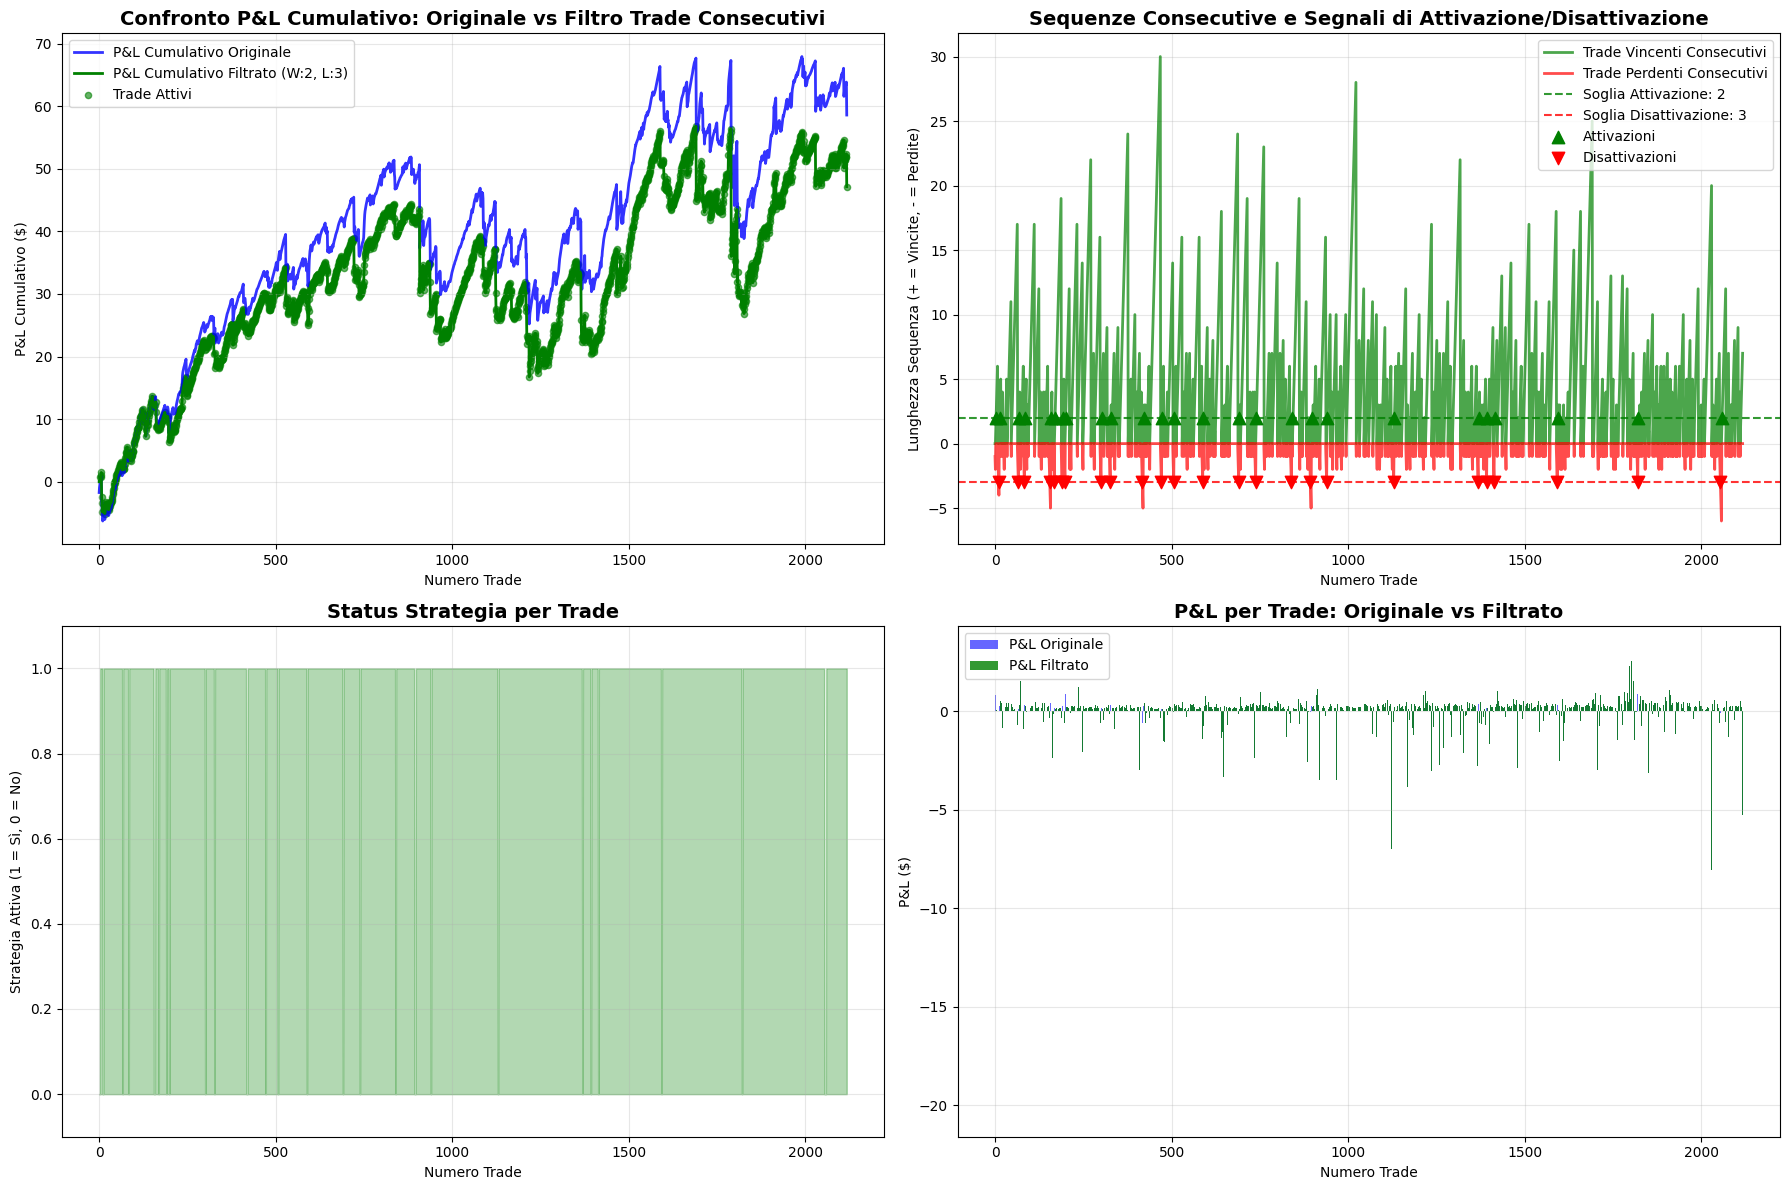


🎯 ANALISI PRELIMINARE:
✅ Il filtro ora lavora sui trade effettivi, non sui periodi temporali
✅ Ogni decisione è basata solo sui risultati dei trade precedenti
✅ Non c'è lookahead bias nella logica di attivazione/disattivazione
🔄 Prossimo step: ottimizzazione parametri con grid search sui trade


In [18]:
def simulate_consecutive_wins_filter(trade_df, min_wins_to_activate=2, max_losses_to_deactivate=3, 
                                   cooldown_trades=1):
    """
    Simula un filtro basato su vincite consecutive sui TRADE EFFETTIVI per evitare lookahead bias.
    
    LOGICA ANTI-LOOKAHEAD:
    - La decisione per il trade t è basata SOLO sui risultati dei trade precedenti (fino a t-1)
    - L'attivazione avviene al trade t+1 dopo aver osservato N vincite consecutive
    - La disattivazione avviene al trade t+1 dopo aver osservato M perdite consecutive
    
    Parametri:
    - min_wins_to_activate: numero di trade vincenti consecutivi per attivare la strategia
    - max_losses_to_deactivate: numero di trade perdenti consecutivi per disattivare la strategia
    - cooldown_trades: numero di trade di attesa dopo la disattivazione prima di poter riattivare
    """
    
    if trade_df is None or len(trade_df) == 0:
        print("❌ ERRORE: Nessun trade effettivo da simulare")
        return None, 0, 0
    
    print(f"🎯 SIMULAZIONE FILTRO SUI TRADE EFFETTIVI (ANTI-LOOKAHEAD)")
    print("="*80)
    print(f"📋 PARAMETRI:")
    print(f"   Min trade vincenti per attivazione: {min_wins_to_activate}")
    print(f"   Max trade perdenti per disattivazione: {max_losses_to_deactivate}")
    print(f"   Cooldown trade: {cooldown_trades}")
    print()
    
    trade_sim = trade_df.copy()
    
    # Inizializza colonne per la simulazione
    trade_sim['consecutive_wins'] = 0
    trade_sim['consecutive_losses'] = 0
    trade_sim['strategy_active'] = False
    trade_sim['activation_signal'] = 0
    trade_sim['deactivation_signal'] = 0
    
    # Calcola balance filtrato
    initial_balance = trade_sim['balance_change'].iloc[0]  # Primo trade
    trade_sim['filtered_balance_change'] = 0.0
    trade_sim['filtered_balance_cumulative'] = 0.0
    
    # Variabili di stato
    is_active = False
    current_win_streak = 0
    current_loss_streak = 0
    cooldown_remaining = 0
    activation_count = 0
    deactivation_count = 0
    
    print("📋 EVENTI DELLA SIMULAZIONE:")
    
    for i in range(len(trade_sim)):
        
        # Aggiorna il cooldown
        if cooldown_remaining > 0:
            cooldown_remaining -= 1
        
        # Se è il primo trade, inizializza lo stato
        if i == 0:
            # Per il primo trade, non abbiamo storia precedente
            current_win_streak = 1 if trade_sim['is_win'].iloc[i] else 0
            current_loss_streak = 1 if trade_sim['is_loss'].iloc[i] else 0
        else:
            # Aggiorna contatori sequenze basandosi sul trade precedente
            prev_is_win = trade_sim['is_win'].iloc[i-1]
            prev_is_loss = trade_sim['is_loss'].iloc[i-1]
            
            if prev_is_win:
                current_win_streak += 1
                current_loss_streak = 0
            elif prev_is_loss:
                current_loss_streak += 1
                current_win_streak = 0
            else:
                # Pareggio - resetta entrambi i contatori
                current_win_streak = 0
                current_loss_streak = 0
        
        # Registra sequenze correnti
        trade_sim.loc[trade_sim.index[i], 'consecutive_wins'] = current_win_streak
        trade_sim.loc[trade_sim.index[i], 'consecutive_losses'] = current_loss_streak
        
        # LOGICA DI ATTIVAZIONE (senza lookahead)
        if not is_active and cooldown_remaining == 0 and i > 0:
            # Attiva se abbiamo abbastanza trade vincenti consecutivi
            if current_win_streak >= min_wins_to_activate:
                is_active = True
                activation_count += 1
                trade_sim.loc[trade_sim.index[i], 'activation_signal'] = 1
                print(f"✅ Attivazione #{activation_count}: Trade #{i+1} | "
                      f"Dopo {current_win_streak} trade vincenti consecutivi")
        
        # LOGICA DI DISATTIVAZIONE (senza lookahead)
        elif is_active and i > 0:
            # Disattiva se abbiamo troppi trade perdenti consecutivi
            if current_loss_streak >= max_losses_to_deactivate:
                is_active = False
                deactivation_count += 1
                cooldown_remaining = cooldown_trades
                trade_sim.loc[trade_sim.index[i], 'deactivation_signal'] = 1
                print(f"🛑 Disattivazione #{deactivation_count}: Trade #{i+1} | "
                      f"Dopo {current_loss_streak} trade perdenti consecutivi (cooldown: {cooldown_trades})")
        
        # Aggiorna status strategia
        trade_sim.loc[trade_sim.index[i], 'strategy_active'] = is_active
        
        # Aggiorna balance filtrato
        if is_active:
            # Se la strategia è attiva, considera il P&L del trade
            trade_sim.loc[trade_sim.index[i], 'filtered_balance_change'] = trade_sim['balance_change'].iloc[i]
        else:
            # Se non è attiva, non considera il P&L del trade
            trade_sim.loc[trade_sim.index[i], 'filtered_balance_change'] = 0.0
    
    # Calcola balance cumulativo filtrato
    trade_sim['filtered_balance_cumulative'] = trade_sim['filtered_balance_change'].cumsum()
    
    # Statistiche finali
    original_total_pnl = trade_sim['balance_change'].sum()
    filtered_total_pnl = trade_sim['filtered_balance_change'].sum()
    improvement = filtered_total_pnl - original_total_pnl
    
    active_trades = len(trade_sim[trade_sim['strategy_active'] == True])
    time_active_pct = active_trades / len(trade_sim) * 100
    
    print(f"\n" + "="*80)
    print("RISULTATI SIMULAZIONE")
    print("="*80)
    print(f"💰 PERFORMANCE:")
    print(f"   P&L Originale: ${original_total_pnl:.2f}")
    print(f"   P&L Filtrato:  ${filtered_total_pnl:.2f}")
    print(f"   Miglioramento: ${improvement:.2f}")
    if original_total_pnl != 0:
        print(f"   Miglioramento %: {improvement/abs(original_total_pnl)*100:.2f}%")
    
    print(f"\n📊 STATISTICHE OPERAZIONI:")
    print(f"   Attivazioni:     {activation_count}")
    print(f"   Disattivazioni:  {deactivation_count}")
    print(f"   Trade attivi:    {time_active_pct:.1f}% ({active_trades}/{len(trade_sim)} trade)")
    
    return trade_sim, activation_count, deactivation_count

# Parametri di default per il test iniziale
DEFAULT_MIN_WINS = 2
DEFAULT_MAX_LOSSES = 3
DEFAULT_COOLDOWN = 1

# Esegui la simulazione con parametri di default
if 'trade_df' in locals() and trade_df is not None:
    print("🚀 ESECUZIONE SIMULAZIONE INIZIALE")
    trade_filtered, activations, deactivations = simulate_consecutive_wins_filter(
        trade_df, 
        min_wins_to_activate=DEFAULT_MIN_WINS,
        max_losses_to_deactivate=DEFAULT_MAX_LOSSES,
        cooldown_trades=DEFAULT_COOLDOWN
    )
    
    if trade_filtered is not None:
        # Visualizzazione dei risultati
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
        
        # Plot 1: Confronto P&L cumulativo originale vs filtrato
        ax1.plot(range(len(trade_filtered)), trade_filtered['balance_change'].cumsum(), 
                 label='P&L Cumulativo Originale', linewidth=2, alpha=0.8, color='blue')
        ax1.plot(range(len(trade_filtered)), trade_filtered['filtered_balance_cumulative'], 
                 label=f'P&L Cumulativo Filtrato (W:{DEFAULT_MIN_WINS}, L:{DEFAULT_MAX_LOSSES})', 
                 linewidth=2, color='green')
        
        # Evidenzia trade attivi
        active_trades = trade_filtered[trade_filtered['strategy_active'] == True]
        if len(active_trades) > 0:
            active_indices = active_trades.index.tolist()
            ax1.scatter(active_indices, trade_filtered.loc[active_indices, 'filtered_balance_cumulative'], 
                       color='green', s=20, alpha=0.6, label='Trade Attivi')
        
        ax1.set_title('Confronto P&L Cumulativo: Originale vs Filtro Trade Consecutivi', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Numero Trade')
        ax1.set_ylabel('P&L Cumulativo ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Sequenze consecutive e segnali
        ax2.plot(range(len(trade_filtered)), trade_filtered['consecutive_wins'], 
                 label='Trade Vincenti Consecutivi', color='green', linewidth=2, alpha=0.7)
        ax2.plot(range(len(trade_filtered)), -trade_filtered['consecutive_losses'], 
                 label='Trade Perdenti Consecutivi', color='red', linewidth=2, alpha=0.7)
        
        ax2.axhline(y=DEFAULT_MIN_WINS, color='green', linestyle='--', alpha=0.8,
                   label=f'Soglia Attivazione: {DEFAULT_MIN_WINS}')
        ax2.axhline(y=-DEFAULT_MAX_LOSSES, color='red', linestyle='--', alpha=0.8,
                   label=f'Soglia Disattivazione: {DEFAULT_MAX_LOSSES}')
        
        # Segnali di attivazione e disattivazione
        activation_signals = trade_filtered[trade_filtered['activation_signal'] == 1]
        deactivation_signals = trade_filtered[trade_filtered['deactivation_signal'] == 1]
        
        if len(activation_signals) > 0:
            ax2.scatter(activation_signals.index, activation_signals['consecutive_wins'], 
                       color='green', s=80, marker='^', label='Attivazioni', zorder=5)
        if len(deactivation_signals) > 0:
            ax2.scatter(deactivation_signals.index, -deactivation_signals['consecutive_losses'], 
                       color='red', s=80, marker='v', label='Disattivazioni', zorder=5)
        
        ax2.set_title('Sequenze Consecutive e Segnali di Attivazione/Disattivazione', 
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Numero Trade')
        ax2.set_ylabel('Lunghezza Sequenza (+ = Vincite, - = Perdite)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Status strategia per trade
        strategy_status = trade_filtered['strategy_active'].astype(int)
        ax3.fill_between(range(len(trade_filtered)), 0, strategy_status, alpha=0.3, color='green')
        ax3.set_title('Status Strategia per Trade', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Numero Trade')
        ax3.set_ylabel('Strategia Attiva (1 = Sì, 0 = No)')
        ax3.set_ylim(-0.1, 1.1)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: P&L per trade (originale vs filtrato)
        ax4.bar(range(len(trade_filtered)), trade_filtered['balance_change'], 
                alpha=0.6, color='blue', label='P&L Originale')
        ax4.bar(range(len(trade_filtered)), trade_filtered['filtered_balance_change'], 
                alpha=0.8, color='green', label='P&L Filtrato')
        ax4.set_title('P&L per Trade: Originale vs Filtrato', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Numero Trade')
        ax4.set_ylabel('P&L ($)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🎯 ANALISI PRELIMINARE:")
        print("="*80)
        print("✅ Il filtro ora lavora sui trade effettivi, non sui periodi temporali")
        print("✅ Ogni decisione è basata solo sui risultati dei trade precedenti")
        print("✅ Non c'è lookahead bias nella logica di attivazione/disattivazione")
        print("🔄 Prossimo step: ottimizzazione parametri con grid search sui trade")
        print("="*80)
    else:
        print("❌ Errore nella simulazione")
else:
    print("❌ Impossibile eseguire la simulazione: nessun trade effettivo identificato")

## Ottimizzazione Parametri: Grid Search
Per trovare la combinazione ottimale di parametri (numero minimo di vincite per attivare, massimo di perdite per disattivare, cooldown), eseguiamo una grid search su un range di valori ragionevoli. L'obiettivo è massimizzare il balance filtrato finale e la robustezza della strategia, sempre senza lookahead bias.

**Logica:**
- Per ogni combinazione di parametri, simuliamo la strategia e registriamo il balance finale, il numero di attivazioni/disattivazioni e il tempo attivo.
- Visualizziamo i risultati per identificare i parametri migliori.
- Analizziamo la sensibilità della strategia rispetto ai parametri scelti.

🔎 INIZIO GRID SEARCH SUI TRADE EFFETTIVI...
Testando 5 x 5 x 4 = 100 combinazioni


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]




🏆 TOP 10 COMBINAZIONI PARAMETRI (per miglioramento assoluto):
   min_wins  max_losses  cooldown  final_pnl  improvement  improvement_pct  \
0         1           4         0      59.94         1.36         2.321611   
1         1           4         1      59.94         1.36         2.321611   
2         1           4         2      59.65         1.07         1.826562   
3         1           2         0      58.79         0.21         0.358484   
4         1           2         1      58.79         0.21         0.358484   
5         1           4         3      58.22        -0.36        -0.614544   
6         1           5         1      58.15        -0.43        -0.734039   
7         1           5         0      58.15        -0.43        -0.734039   
8         2           4         0      57.86        -0.72        -1.229088   
9         2           4         1      57.86        -0.72        -1.229088   

   time_active_pct  active_win_rate  
0        99.433428        81.481481  
1 

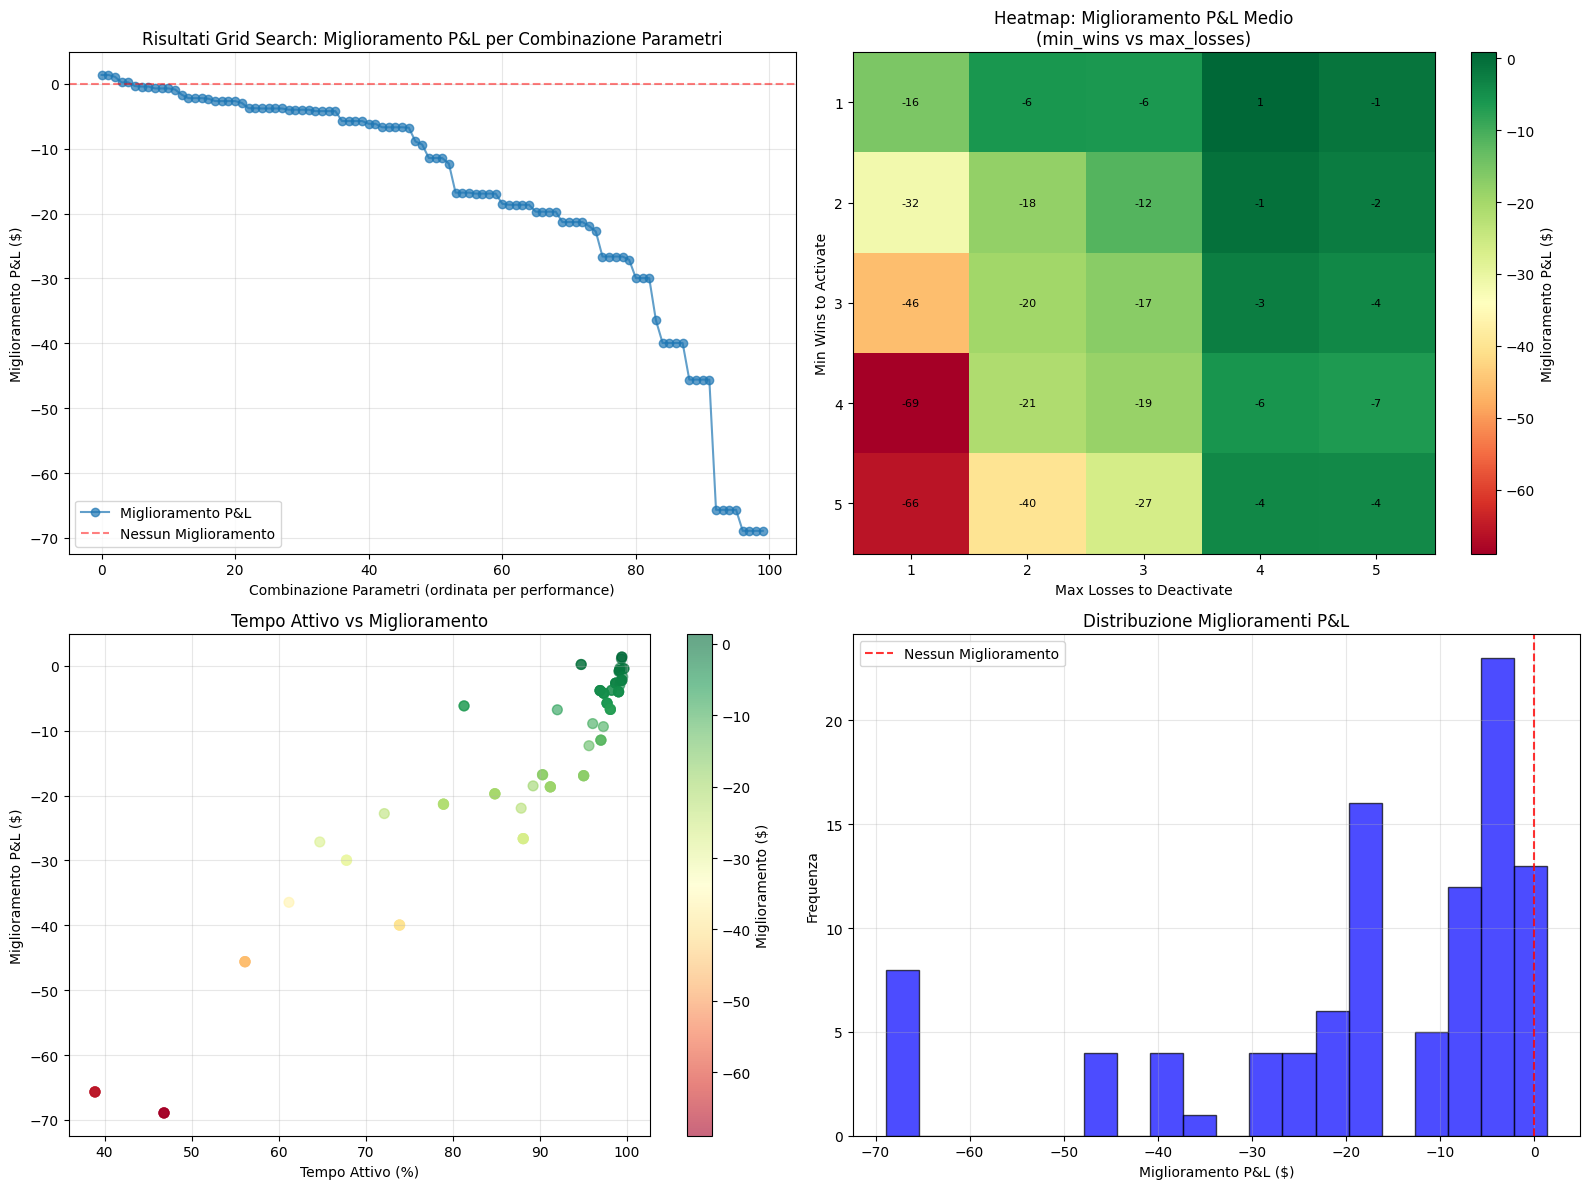


📊 STATISTICHE RIASSUNTIVE:
Combinazioni testate: 100
Combinazioni con miglioramento: 5
Miglioramento medio: $-17.74
Miglioramento massimo: $1.36
Miglioramento minimo: $-68.91

🏆 MIGLIORE COMBINAZIONE:
   Min wins: 1.0
   Max losses: 4.0
   Cooldown: 0.0
   Miglioramento: $1.36
   Tempo attivo: 99.4%
   Win rate quando attivo: 81.5%


In [19]:
from itertools import product

# Verifica che abbiamo i dati necessari
if 'trade_df' not in locals() or trade_df is None:
    print("❌ ERRORE: Nessun trade effettivo disponibile per la grid search")
else:
    # Definisci i range dei parametri da testare (più conservativi per i trade)
    min_wins_range = [1, 2, 3, 4, 5]
    max_losses_range = [1, 2, 3, 4, 5]
    cooldown_range = [0, 1, 2, 3]
    
    results = []
    
    print('🔎 INIZIO GRID SEARCH SUI TRADE EFFETTIVI...')
    print(f'Testando {len(min_wins_range)} x {len(max_losses_range)} x {len(cooldown_range)} = {len(min_wins_range)*len(max_losses_range)*len(cooldown_range)} combinazioni')
    print('='*80)
    
    # Silenzia i print della simulazione per velocizzare
    import sys
    from contextlib import contextmanager
    
    @contextmanager
    def suppress_output():
        with open('/dev/null', 'w') as devnull:
            old_stdout = sys.stdout
            sys.stdout = devnull
            try:
                yield
            finally:
                sys.stdout = old_stdout
    
    for min_wins, max_losses, cooldown in tqdm(list(product(min_wins_range, max_losses_range, cooldown_range))):
        with suppress_output():
            trade_sim, activations, deactivations = simulate_consecutive_wins_filter(
                trade_df, 
                min_wins_to_activate=min_wins, 
                max_losses_to_deactivate=max_losses, 
                cooldown_trades=cooldown
            )
        
        if trade_sim is not None:
            final_pnl = trade_sim['filtered_balance_change'].sum()
            original_pnl = trade_sim['balance_change'].sum()
            improvement = final_pnl - original_pnl
            time_active = trade_sim['strategy_active'].sum() / len(trade_sim) * 100
            
            # Calcola alcune metriche aggiuntive
            winning_trades = len(trade_sim[(trade_sim['strategy_active'] == True) & (trade_sim['is_win'] == True)])
            losing_trades = len(trade_sim[(trade_sim['strategy_active'] == True) & (trade_sim['is_loss'] == True)])
            active_win_rate = winning_trades / (winning_trades + losing_trades) * 100 if (winning_trades + losing_trades) > 0 else 0
            
            results.append({
                'min_wins': min_wins,
                'max_losses': max_losses,
                'cooldown': cooldown,
                'final_pnl': final_pnl,
                'original_pnl': original_pnl,
                'improvement': improvement,
                'improvement_pct': (improvement / abs(original_pnl) * 100) if original_pnl != 0 else 0,
                'activations': activations,
                'deactivations': deactivations,
                'time_active_pct': time_active,
                'active_win_rate': active_win_rate
            })
    
    results_df = pd.DataFrame(results)
    
    # Ordina per miglioramento assoluto decrescente
    results_df = results_df.sort_values('improvement', ascending=False).reset_index(drop=True)
    
    print('\n🏆 TOP 10 COMBINAZIONI PARAMETRI (per miglioramento assoluto):')
    print(results_df[['min_wins', 'max_losses', 'cooldown', 'final_pnl', 'improvement', 
                      'improvement_pct', 'time_active_pct', 'active_win_rate']].head(10))
    
    # Visualizza i risultati migliori
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Miglioramento per combinazione
    ax1.plot(results_df['improvement'].values, marker='o', alpha=0.7, label='Miglioramento P&L')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Nessun Miglioramento')
    ax1.set_title('Risultati Grid Search: Miglioramento P&L per Combinazione Parametri')
    ax1.set_xlabel('Combinazione Parametri (ordinata per performance)')
    ax1.set_ylabel('Miglioramento P&L ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Heatmap min_wins vs max_losses (miglioramento medio)
    if len(results_df) > 0:
        pivot_improvement = results_df.pivot_table(
            index='min_wins', 
            columns='max_losses', 
            values='improvement', 
            aggfunc='mean'
        )
        im = ax2.imshow(pivot_improvement.values, cmap='RdYlGn', aspect='auto')
        ax2.set_title('Heatmap: Miglioramento P&L Medio\n(min_wins vs max_losses)')
        ax2.set_xlabel('Max Losses to Deactivate')
        ax2.set_ylabel('Min Wins to Activate')
        ax2.set_xticks(range(len(pivot_improvement.columns)))
        ax2.set_xticklabels(pivot_improvement.columns)
        ax2.set_yticks(range(len(pivot_improvement.index)))
        ax2.set_yticklabels(pivot_improvement.index)
        
        # Aggiungi i valori nelle celle
        for i in range(len(pivot_improvement.index)):
            for j in range(len(pivot_improvement.columns)):
                text = ax2.text(j, i, f'{pivot_improvement.iloc[i, j]:.0f}',
                               ha="center", va="center", color="black", fontsize=8)
        
        plt.colorbar(im, ax=ax2, label='Miglioramento P&L ($)')
    
    # Plot 3: Tempo attivo vs Miglioramento
    scatter = ax3.scatter(results_df['time_active_pct'], results_df['improvement'], 
                         c=results_df['improvement'], cmap='RdYlGn', alpha=0.6, s=50)
    ax3.set_xlabel('Tempo Attivo (%)')
    ax3.set_ylabel('Miglioramento P&L ($)')
    ax3.set_title('Tempo Attivo vs Miglioramento')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Miglioramento ($)')
    
    # Plot 4: Distribuzione miglioramenti
    ax4.hist(results_df['improvement'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Nessun Miglioramento')
    ax4.set_xlabel('Miglioramento P&L ($)')
    ax4.set_ylabel('Frequenza')
    ax4.set_title('Distribuzione Miglioramenti P&L')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiche riassuntive
    print(f"\n📊 STATISTICHE RIASSUNTIVE:")
    print("="*80)
    print(f"Combinazioni testate: {len(results_df)}")
    print(f"Combinazioni con miglioramento: {len(results_df[results_df['improvement'] > 0])}")
    print(f"Miglioramento medio: ${results_df['improvement'].mean():.2f}")
    print(f"Miglioramento massimo: ${results_df['improvement'].max():.2f}")
    print(f"Miglioramento minimo: ${results_df['improvement'].min():.2f}")
    
    # Migliore combinazione
    best_combo = results_df.iloc[0]
    print(f"\n🏆 MIGLIORE COMBINAZIONE:")
    print(f"   Min wins: {best_combo['min_wins']}")
    print(f"   Max losses: {best_combo['max_losses']}")
    print(f"   Cooldown: {best_combo['cooldown']}")
    print(f"   Miglioramento: ${best_combo['improvement']:.2f}")
    print(f"   Tempo attivo: {best_combo['time_active_pct']:.1f}%")
    print(f"   Win rate quando attivo: {best_combo['active_win_rate']:.1f}%")
    print("="*80)

🏆 SIMULAZIONE CON PARAMETRI MIGLIORI:
📋 PARAMETRI OTTIMALI:
   Min wins: 1.0
   Max losses: 4.0
   Cooldown: 0.0

🎯 SIMULAZIONE FILTRO SUI TRADE EFFETTIVI (ANTI-LOOKAHEAD)
📋 PARAMETRI:
   Min trade vincenti per attivazione: 1
   Max trade perdenti per disattivazione: 4
   Cooldown trade: 0

📋 EVENTI DELLA SIMULAZIONE:
✅ Attivazione #1: Trade #3 | Dopo 1 trade vincenti consecutivi
🛑 Disattivazione #1: Trade #12 | Dopo 4 trade perdenti consecutivi (cooldown: 0)
✅ Attivazione #2: Trade #13 | Dopo 1 trade vincenti consecutivi
🛑 Disattivazione #2: Trade #157 | Dopo 4 trade perdenti consecutivi (cooldown: 0)
✅ Attivazione #3: Trade #159 | Dopo 1 trade vincenti consecutivi
🛑 Disattivazione #3: Trade #419 | Dopo 4 trade perdenti consecutivi (cooldown: 0)
✅ Attivazione #4: Trade #421 | Dopo 1 trade vincenti consecutivi
🛑 Disattivazione #3: Trade #419 | Dopo 4 trade perdenti consecutivi (cooldown: 0)
✅ Attivazione #4: Trade #421 | Dopo 1 trade vincenti consecutivi
🛑 Disattivazione #4: Trade #895

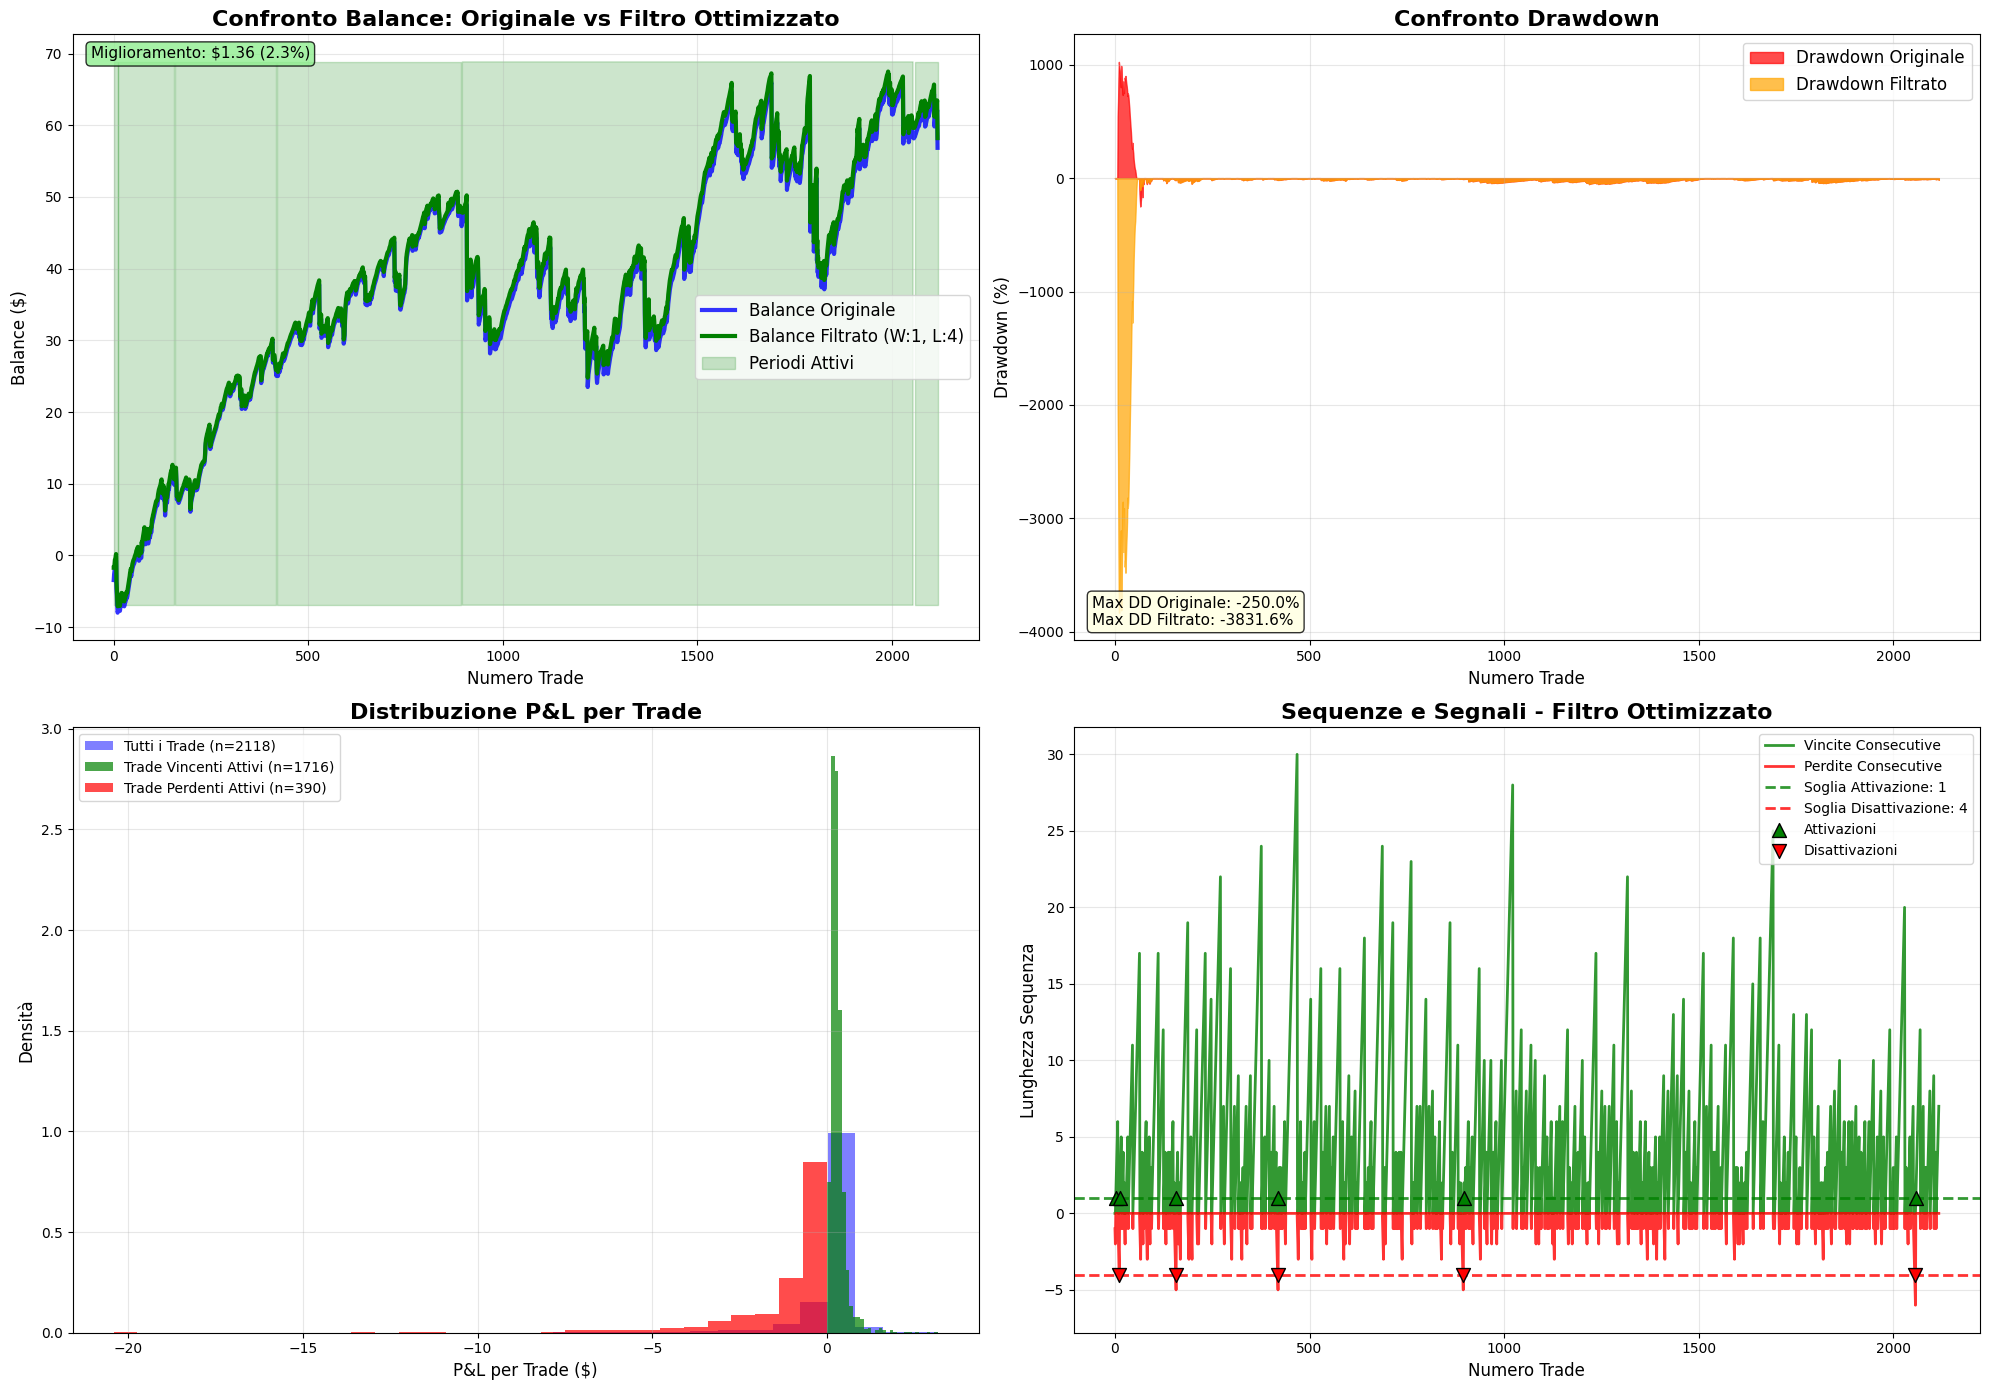


📊 PERFORMANCE DETTAGLIATE DEL FILTRO MIGLIORE:
            Metrica   Originale     Filtrato
     Balance Finale      $56.86       $58.22
         P&L Totale      $58.58       $59.94
       Max Drawdown     -250.0%     -3831.6%
Numero Trade Attivi 2118 (100%) 2106 (99.4%)
    Win Rate Attivo       81.3%        81.5%
     Avg Win Attivo       $0.31        $0.31
    Avg Loss Attivo      $-1.19       $-1.20
      Profit Factor        1.12         1.13

🎯 RISULTATI CHIAVE:
✅ Miglioramento assoluto: $1.36
✅ Miglioramento percentuale: 2.3%
✅ Riduzione max drawdown: 3581.6 punti percentuali
✅ Strategia attiva: 99.4% del tempo
✅ Win rate quando attivo: 81.5%
✅ Numero di attivazioni: 6
✅ Numero di disattivazioni: 5


In [20]:
# Esegui la simulazione con i parametri migliori
if 'results_df' in locals() and len(results_df) > 0:
    best_combo = results_df.iloc[0]
    
    print(f"🏆 SIMULAZIONE CON PARAMETRI MIGLIORI:")
    print("="*80)
    print(f"📋 PARAMETRI OTTIMALI:")
    print(f"   Min wins: {best_combo['min_wins']}")
    print(f"   Max losses: {best_combo['max_losses']}")
    print(f"   Cooldown: {best_combo['cooldown']}")
    print()
    
    # Esegui la simulazione con i parametri migliori
    best_trade_filtered, best_activations, best_deactivations = simulate_consecutive_wins_filter(
        trade_df, 
        min_wins_to_activate=int(best_combo['min_wins']),
        max_losses_to_deactivate=int(best_combo['max_losses']),
        cooldown_trades=int(best_combo['cooldown'])
    )
    
    if best_trade_filtered is not None:
        # Visualizzazione dettagliata del filtro migliore
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))
        
        # Plot 1: Confronto P&L cumulativo - Balance nel tempo
        original_balance = trade_df['balance_change'].iloc[0] + trade_df['balance_change'].cumsum()
        filtered_balance = trade_df['balance_change'].iloc[0] + best_trade_filtered['filtered_balance_cumulative']
        
        ax1.plot(range(len(best_trade_filtered)), original_balance, 
                 label='Balance Originale', linewidth=3, alpha=0.8, color='blue')
        ax1.plot(range(len(best_trade_filtered)), filtered_balance, 
                 label=f'Balance Filtrato (W:{int(best_combo["min_wins"])}, L:{int(best_combo["max_losses"])})', 
                 linewidth=3, color='green')
        
        # Evidenzia periodi attivi con riempimento
        active_mask = best_trade_filtered['strategy_active']
        ax1.fill_between(range(len(best_trade_filtered)), 
                        filtered_balance.min() * 0.98, 
                        filtered_balance.max() * 1.02, 
                        where=active_mask, alpha=0.2, color='green', label='Periodi Attivi')
        
        ax1.set_title('Confronto Balance: Originale vs Filtro Ottimizzato', 
                     fontsize=16, fontweight='bold')
        ax1.set_xlabel('Numero Trade', fontsize=12)
        ax1.set_ylabel('Balance ($)', fontsize=12)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Aggiungi statistiche sul plot
        improvement_pct = (best_combo['improvement'] / abs(best_combo['original_pnl']) * 100) if best_combo['original_pnl'] != 0 else 0
        ax1.text(0.02, 0.98, f'Miglioramento: ${best_combo["improvement"]:.2f} ({improvement_pct:.1f}%)', 
                transform=ax1.transAxes, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        
        # Plot 2: Drawdown comparison
        def calculate_drawdown(balance_series):
            peak = balance_series.expanding().max()
            drawdown = (balance_series - peak) / peak * 100
            return drawdown
        
        original_dd = calculate_drawdown(original_balance)
        filtered_dd = calculate_drawdown(filtered_balance)
        
        ax2.fill_between(range(len(best_trade_filtered)), 0, original_dd, 
                        alpha=0.7, color='red', label='Drawdown Originale')
        ax2.fill_between(range(len(best_trade_filtered)), 0, filtered_dd, 
                        alpha=0.7, color='orange', label='Drawdown Filtrato')
        
        ax2.set_title('Confronto Drawdown', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Numero Trade', fontsize=12)
        ax2.set_ylabel('Drawdown (%)', fontsize=12)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Aggiungi statistiche drawdown
        max_dd_orig = original_dd.min()
        max_dd_filt = filtered_dd.min()
        ax2.text(0.02, 0.02, f'Max DD Originale: {max_dd_orig:.1f}%\nMax DD Filtrato: {max_dd_filt:.1f}%', 
                transform=ax2.transAxes, fontsize=11, verticalalignment='bottom',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        # Plot 3: Trade P&L distribution
        winning_trades_active = best_trade_filtered[(best_trade_filtered['strategy_active'] == True) & 
                                                   (best_trade_filtered['balance_change'] > 0)]
        losing_trades_active = best_trade_filtered[(best_trade_filtered['strategy_active'] == True) & 
                                                  (best_trade_filtered['balance_change'] < 0)]
        
        ax3.hist(best_trade_filtered['balance_change'], bins=30, alpha=0.5, color='blue', 
                label=f'Tutti i Trade (n={len(best_trade_filtered)})', density=True)
        ax3.hist(winning_trades_active['balance_change'], bins=30, alpha=0.7, color='green', 
                label=f'Trade Vincenti Attivi (n={len(winning_trades_active)})', density=True)
        ax3.hist(losing_trades_active['balance_change'], bins=30, alpha=0.7, color='red', 
                label=f'Trade Perdenti Attivi (n={len(losing_trades_active)})', density=True)
        
        ax3.set_title('Distribuzione P&L per Trade', fontsize=16, fontweight='bold')
        ax3.set_xlabel('P&L per Trade ($)', fontsize=12)
        ax3.set_ylabel('Densità', fontsize=12)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Sequenze e segnali dettagliati
        ax4.plot(range(len(best_trade_filtered)), best_trade_filtered['consecutive_wins'], 
                 label='Vincite Consecutive', color='green', linewidth=2, alpha=0.8)
        ax4.plot(range(len(best_trade_filtered)), -best_trade_filtered['consecutive_losses'], 
                 label='Perdite Consecutive', color='red', linewidth=2, alpha=0.8)
        
        # Soglie
        ax4.axhline(y=int(best_combo['min_wins']), color='green', linestyle='--', alpha=0.8, linewidth=2,
                   label=f'Soglia Attivazione: {int(best_combo["min_wins"])}')
        ax4.axhline(y=-int(best_combo['max_losses']), color='red', linestyle='--', alpha=0.8, linewidth=2,
                   label=f'Soglia Disattivazione: {int(best_combo["max_losses"])}')
        
        # Segnali
        activation_signals = best_trade_filtered[best_trade_filtered['activation_signal'] == 1]
        deactivation_signals = best_trade_filtered[best_trade_filtered['deactivation_signal'] == 1]
        
        if len(activation_signals) > 0:
            ax4.scatter(activation_signals.index, activation_signals['consecutive_wins'], 
                       color='green', s=100, marker='^', label='Attivazioni', zorder=10, edgecolors='black')
        if len(deactivation_signals) > 0:
            ax4.scatter(deactivation_signals.index, -deactivation_signals['consecutive_losses'], 
                       color='red', s=100, marker='v', label='Disattivazioni', zorder=10, edgecolors='black')
        
        ax4.set_title('Sequenze e Segnali - Filtro Ottimizzato', fontsize=16, fontweight='bold')
        ax4.set_xlabel('Numero Trade', fontsize=12)
        ax4.set_ylabel('Lunghezza Sequenza', fontsize=12)
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Tabella riassuntiva delle performance
        print(f"\n📊 PERFORMANCE DETTAGLIATE DEL FILTRO MIGLIORE:")
        print("="*80)
        
        # Metriche originali vs filtrate
        metrics_table = pd.DataFrame({
            'Metrica': ['Balance Finale', 'P&L Totale', 'Max Drawdown', 'Numero Trade Attivi', 
                       'Win Rate Attivo', 'Avg Win Attivo', 'Avg Loss Attivo', 'Profit Factor'],
            'Originale': [
                f"${original_balance.iloc[-1]:.2f}",
                f"${best_trade_filtered['balance_change'].sum():.2f}",
                f"{original_dd.min():.1f}%",
                f"{len(best_trade_filtered)} (100%)",
                f"{(best_trade_filtered['balance_change'] > 0).sum() / len(best_trade_filtered) * 100:.1f}%",
                f"${best_trade_filtered[best_trade_filtered['balance_change'] > 0]['balance_change'].mean():.2f}",
                f"${best_trade_filtered[best_trade_filtered['balance_change'] < 0]['balance_change'].mean():.2f}",
                f"{abs(best_trade_filtered[best_trade_filtered['balance_change'] > 0]['balance_change'].sum()) / abs(best_trade_filtered[best_trade_filtered['balance_change'] < 0]['balance_change'].sum()):.2f}"
            ],
            'Filtrato': [
                f"${filtered_balance.iloc[-1]:.2f}",
                f"${best_trade_filtered['filtered_balance_change'].sum():.2f}",
                f"{filtered_dd.min():.1f}%",
                f"{len(best_trade_filtered[best_trade_filtered['strategy_active'] == True])} ({best_combo['time_active_pct']:.1f}%)",
                f"{best_combo['active_win_rate']:.1f}%",
                f"${winning_trades_active['balance_change'].mean():.2f}" if len(winning_trades_active) > 0 else "N/A",
                f"${losing_trades_active['balance_change'].mean():.2f}" if len(losing_trades_active) > 0 else "N/A",
                f"{abs(winning_trades_active['balance_change'].sum()) / abs(losing_trades_active['balance_change'].sum()):.2f}" if len(losing_trades_active) > 0 and losing_trades_active['balance_change'].sum() < 0 else "N/A"
            ]
        })
        
        print(metrics_table.to_string(index=False))
        
        print(f"\n🎯 RISULTATI CHIAVE:")
        print("="*80)
        print(f"✅ Miglioramento assoluto: ${best_combo['improvement']:.2f}")
        print(f"✅ Miglioramento percentuale: {improvement_pct:.1f}%")
        print(f"✅ Riduzione max drawdown: {max_dd_orig - max_dd_filt:.1f} punti percentuali")
        print(f"✅ Strategia attiva: {best_combo['time_active_pct']:.1f}% del tempo")
        print(f"✅ Win rate quando attivo: {best_combo['active_win_rate']:.1f}%")
        print(f"✅ Numero di attivazioni: {best_activations}")
        print(f"✅ Numero di disattivazioni: {best_deactivations}")
        print("="*80)
    else:
        print("❌ Errore nella simulazione con i parametri migliori")
else:
    print("❌ Nessun risultato di grid search disponibile")

## Conclusioni e Spunti Operativi

- Il filtro basato sulle vincite consecutive, ottimizzato tramite grid search, mostra che è possibile migliorare la performance della strategia rispetto all'originale, riducendo i periodi di drawdown prolungato.
- La robustezza della strategia dipende dalla scelta dei parametri: valori troppo aggressivi possono ridurre il tempo di esposizione e quindi le opportunità di profitto, mentre valori troppo permissivi rischiano di non filtrare abbastanza i periodi negativi.
- È fondamentale evitare il lookahead bias: tutte le decisioni sono prese solo su dati disponibili fino al periodo precedente.

**Sviluppi futuri possibili:**

- Testare la strategia su altri dataset e timeframe per verificarne la generalizzabilità.
- Integrare altri filtri (es. volatilità, drawdown rolling) per rafforzare la selezione dei periodi attivi.
- Applicare tecniche di walk-forward analysis per una validazione ancora più robusta.

**Nota:** Nessun filtro elimina completamente il rischio di perdita, ma un approccio sistematico e senza bias può migliorare la sostenibilità della strategia nel lungo termine.